In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import os

# Определение блока U-Net
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

# Архитектура U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = UNetBlock(1, 64)
        self.encoder2 = UNetBlock(64, 128)
        self.encoder3 = UNetBlock(128, 256)
        self.encoder4 = UNetBlock(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        self.bottleneck = UNetBlock(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = UNetBlock(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = UNetBlock(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = UNetBlock(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = UNetBlock(128, 64)
        
        self.output = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.output(dec1))

# Набор данных для загрузки изображений и масок
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# Настройки и инициализация модели, оптимизатора и функции потерь
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Параметры обучения
num_epochs = 10
batch_size = 8

# Трансформации для изображений
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Путь к изображениям и маскам
image_dir = "C://Users/User/Downloads/imgs/frames"
mask_dir = "C://Users/User/Downloads/imgs/masks"

# Загрузка и разбиение датасета
dataset = MedicalImageDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

print("Обучение завершено.")


Epoch [1/10], Loss: 0.1453
Epoch [2/10], Loss: 0.0633
Epoch [3/10], Loss: 0.0433
Epoch [4/10], Loss: 0.0344
Epoch [5/10], Loss: 0.0301
Epoch [6/10], Loss: 0.0271
Epoch [7/10], Loss: 0.0236
Epoch [8/10], Loss: 0.0229
Epoch [9/10], Loss: 0.0210
Epoch [10/10], Loss: 0.0199
Обучение завершено.


In [2]:
#Сохранение модели
torch.save(model.state_dict(), "unet_model.pth")

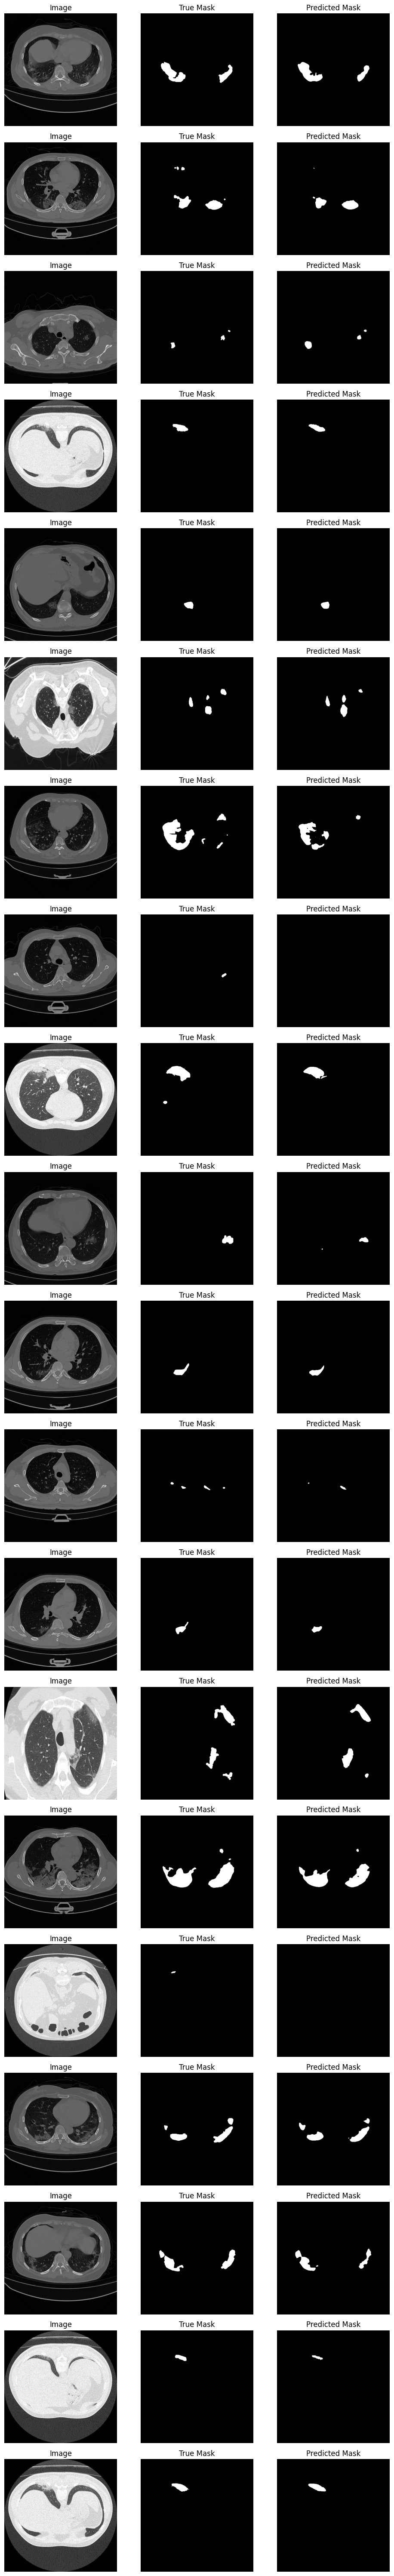

In [3]:
import matplotlib.pyplot as plt

# Функция для тестирования модели
def test_model(model, dataloader, device):
    model.eval()
    test_images = []
    test_masks = []
    pred_masks = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = (outputs > 0.5).float()

            test_images.append(images.cpu())
            test_masks.append(masks.cpu())
            pred_masks.append(outputs.cpu())

    return test_images, test_masks, pred_masks

# Функция для визуализации результатов
def visualize_results(images, masks, preds, num_samples=3):
    plt.figure(figsize=(10, num_samples * 3))
    
    for i in range(num_samples):
        # Исходное изображение
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title("Image")
        plt.axis("off")

        # Истинная маска
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        # Предсказанная маска
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Получение тестовых изображений и предсказанных масок
test_images, test_masks, pred_masks = test_model(model, test_loader, device)

# Визуализация первых трех результатов
visualize_results(test_images, test_masks, pred_masks, num_samples=20)